In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

from fastapi import FastAPI, HTTPException, File, UploadFile
import uvicorn
from pydantic import BaseModel
import requests


# Later, in another script or session, you can load the scaler
loaded_scaler = joblib.load('standard_scaler.pkl')
# Load the saved autoencoder model
loaded_autoencoder = load_model("autoencoder_model.h5")
# Load Featurewise Thresold
feature_wise_threshold = joblib.load("feature_wise_threshold.pkl")
# Thresold for reconstruction loss
threshold = 0.0005

## To make predictions from the server, you can use the following function:


In [6]:
def PredictFromServer(x):
    input_data = {"features": x} 
    # Define the URL of your FastAPI server
    url =  "http://127.0.0.1:8000/predict"  # Replace with the actual URL of your server
    # Send a POST request to the /predict endpoint
    response = requests.post(url, json=input_data)
    result = response.json()

    ReconLoss = result["reconstruction_loss"][0]
    FeatureImportance = result["feature_wise_recon"]

    return ReconLoss, FeatureImportance

# To visualize the iterative process and analyze the contribution of each variable, the following code can be used:


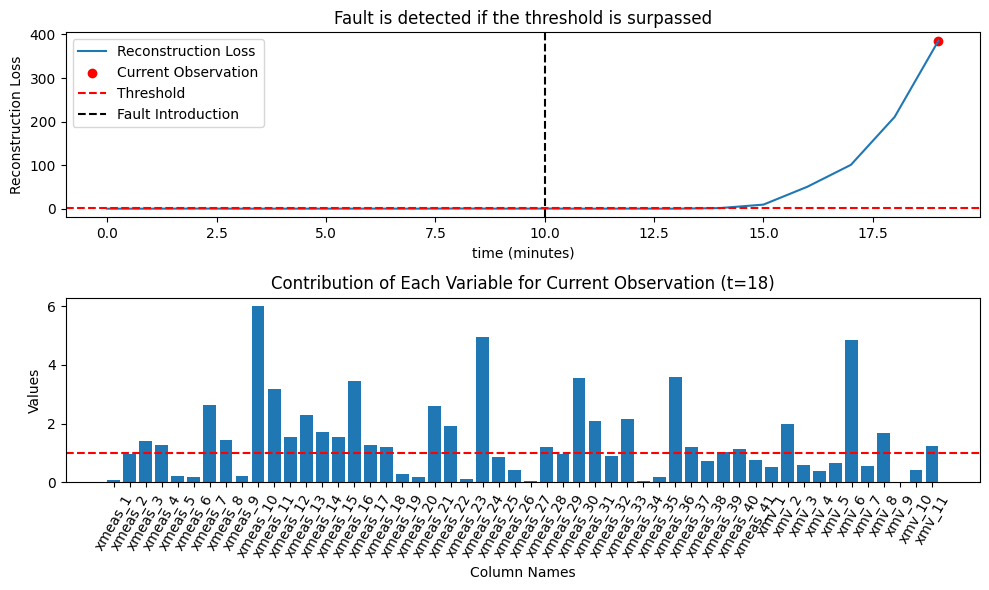

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

test_df = pd.read_csv(r'Dataset/Fault_2.csv') # this can be changed to Fault_1, Fault_2, Fault_4, Fault_6 
test_df = test_df[:40]
test_df = test_df[::2]

column_names = test_df.columns[3:]
ReconLoss=[]



for idx in range(len(test_df)):

    # Create subplots
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

    x  = test_df.iloc[idx,3:].values.tolist()

    RL, FI = PredictFromServer(x)

    ReconLoss.append(RL)


    # Plot Reconstruction Loss iteratively
    axes[0].plot(ReconLoss, label='Reconstruction Loss')
    axes[0].scatter(idx, ReconLoss[idx], color='red', marker='o', label='Current Observation')
    axes[0].axhline(1, c='r', linestyle='--', label='Threshold')  # threshold value
    axes[0].axvline(10, c='k', linestyle='--', label='Fault Introduction',  alpha=1)  # time of fault introduction
    axes[0].set_xlabel('time (minutes)')
    axes[0].set_ylabel('Reconstruction Loss')
    axes[0].set_title('Fault is detected if the threshold is surpassed')
    axes[0].legend()

    # Plot Contribution of Each Variable
    axes[1].bar(column_names, FI)  # Flatten the array to 1D for plotting
    axes[1].axhline(1, c='r', linestyle='--')  # threshold for normal
    axes[1].set_xlabel('Column Names')
    axes[1].set_ylabel('Values')
    axes[1].set_title(f'Contribution of Each Variable for Current Observation (t={idx-1})')
    axes[1].tick_params(axis='x', rotation=60)  # Rotate x-tick labels for better visibility

    # Display the plots
    plt.tight_layout()
    plt.show()
    clear_output(wait=True)
    

    # Clear the output for a clean display in Jupyter Notebook
    


# Create an animation and save as a GIF

MovieWriter imagemagick unavailable; using Pillow instead.


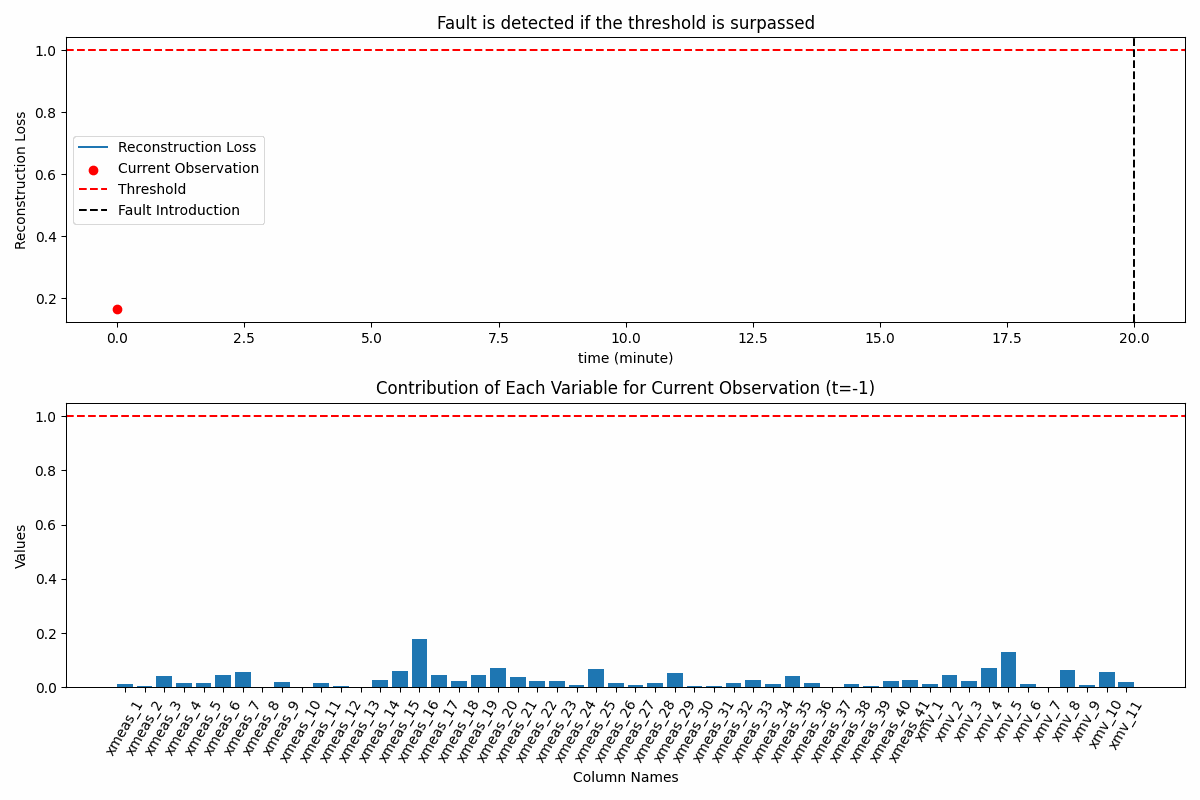

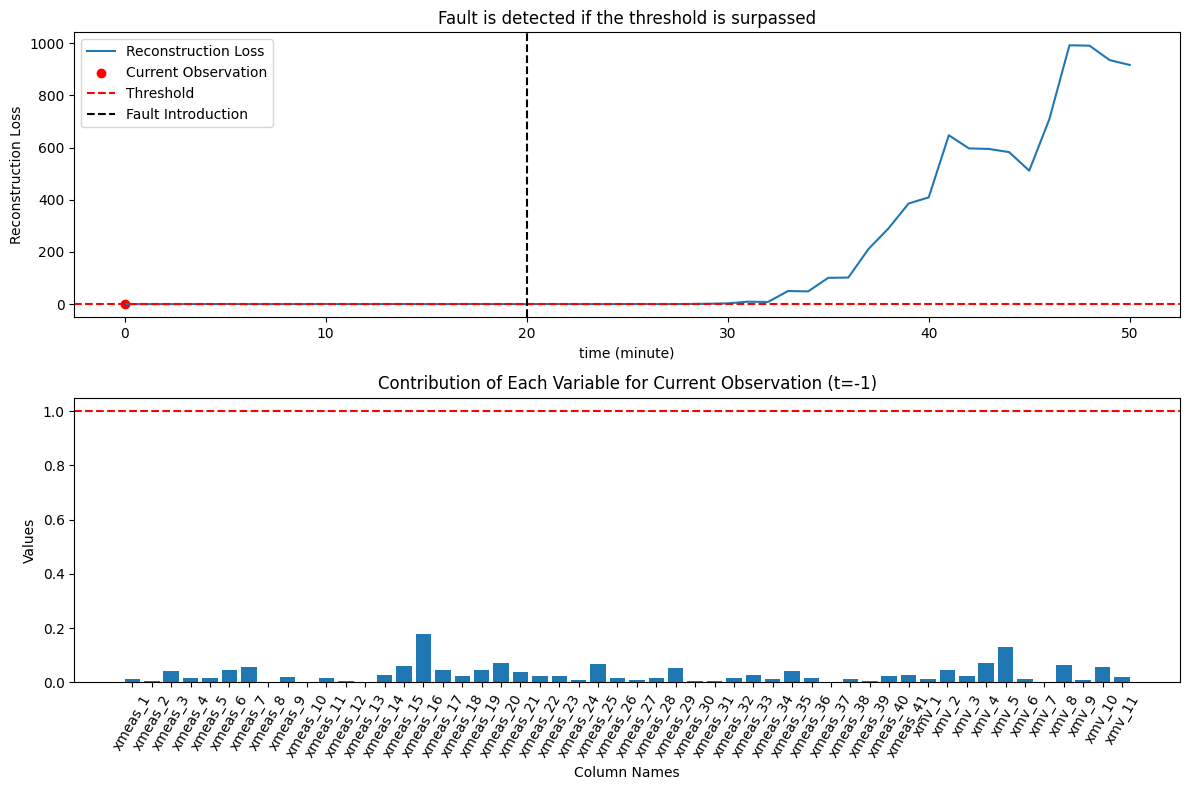

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib.animation import FuncAnimation

test_df = pd.read_csv(r'Dataset/Fault_2.csv')
test_df = test_df[:50]

column_names = test_df.columns[3:]
ReconLoss=[]
# Create subplots outside the loop
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))


# Update function for the animation
def update(idx):
    x = test_df.iloc[idx, 3:].values.tolist()

    RL, FI = PredictFromServer(x)

    ReconLoss.append(RL)

    axes[0].clear()
    axes[1].clear()
    # Plot Reconstruction Loss iteratively
    axes[0].plot(ReconLoss[:-1], label='Reconstruction Loss')
    axes[0].scatter(idx, ReconLoss[idx], color='red', marker='o', label='Current Observation')
    axes[0].axhline(1, c='r', linestyle='--', label='Threshold')  # threshold value
    axes[0].axvline(20, c='k', linestyle='--', label='Fault Introduction', alpha=1)  # time of fault introduction
    axes[0].set_xlabel('time (minute)')
    axes[0].set_ylabel('Reconstruction Loss')
    axes[0].set_title('Fault is detected if the threshold is surpassed')
    axes[0].legend()

    # Plot Contribution of Each Variable
    axes[1].bar(column_names, FI)  # Flatten the array to 1D for plotting
    axes[1].axhline(1, c='r', linestyle='--')  # threshold for normal
    axes[1].set_xlabel('Column Names')
    axes[1].set_ylabel('Values')
    axes[1].set_title(f'Contribution of Each Variable for Current Observation (t={idx-1})')
    axes[1].tick_params(axis='x', rotation=60)  # Rotate x-tick labels for better visibility

    plt.tight_layout()
# Create the animation
animation = FuncAnimation(fig, update, frames=len(test_df), repeat=False)

# Save the animation as a GIF
animation.save('animation.gif', writer='imagemagick', fps=2)

# Display the saved GIF
from IPython.display import Image
Image(filename="animation.gif")
